**Disclaimer: not for financial recommandation, educational purpose only.**

The interest rate is farely low right now, however, is it really a free lunch to refinance - even no point no fee?  I am going to show you how to analyze it by yourself.  This is just a toy model, for your investment, please do your own due diligence.<!-- TEASER_END -->


# Find the tool

There is no need to reinvent the wheel, especially to code something up.
Here I reuse a package from [jbmohler](https://github.com/jbmohler/mortgage) to compute the mortgage with a few modifications.

In [ ]:
!rm -f mortgage.py*
!wget -q https://raw.githubusercontent.com/jiayiliu/mortgage/master/mortgage.py

In [ ]:
import mortgage
from itertools import islice
import matplotlib.pylab as plt
%matplotlib inline

First, let's see the baseline - both for the original loan and for the usage of the mortgage package.

In [ ]:
# Basic Setup
# interest rate for 30-fixed - 4%
ORIGIN_INTEREST=0.04
# Initial loan amount - 1 Million Dollar
INITIAL_AMOUNT = 1e6
# Number of months
PERIOD=360

m = mortgage.Mortgage(interest=ORIGIN_INTEREST, amount=INITIAL_AMOUNT, months=PERIOD)
mortgage.print_summary(m)

# Refinance

Now let's build a function to calculate the refinance:
Assuming we will switch the loan at `time_idx` month.  And the interest rate will be changed to `new_interest` and we will take `remaining` months to pay off the loan.

The function returns the interest and principle payments for the first and second mortgages.

We will address three questions: 

1. what's the trick in the refinance?
2. what's the break-even point for refinance?
3. what's the better strategy?

In [ ]:
def refinance(mort, time_idx, new_interest=ORIGIN_INTEREST, remaining=PERIOD):
  """
  compute the refinance payout.
  
  :param mort: mortgage object
  :param time_idx: which month to switch
  :param new_interest: new interest rate
  :param remaining: the term of the new loan
  :return: payouts - interest paid for first loan, principle paid for first loan, interest paid for the second loan, priciple paid for the second loan.
  """
  payments = [p for p in islice(mort.monthly_payment_schedule(), time_idx)]
  prev_principle = sum(p[0] for p in payments )
  prev_interest = sum(p[1] for p in payments)
  left = mortgage.dollar(mort.amount() - prev_principle)
  
  new_mort = mortgage.Mortgage(interest=new_interest, amount=left, months=remaining)
  payments = [p for p in new_mort.monthly_payment_schedule()]
  new_principle = sum(p[0] for p in payments )
  new_interest = sum(p[1] for p in payments)
  return prev_interest, prev_principle, new_interest, new_principle

# verify the function is right, minor difference due to rounding
res = [refinance(m, i) for i in range(0,PERIOD+1,12)]
for r in res:  # principles are equal
  assert r[1]+r[3] == INITIAL_AMOUNT



## When refinance for another 30yr fixed

Assuming the rate stays the same, by refinancing for another 30 years, we are paying way more interests even the monthly payment is lower. 

In [ ]:
# interests diff
total_interest = float(m.total_payout())-INITIAL_AMOUNT


res = [refinance(m, i) for i in range(0,PERIOD+1,12)]
interests = [r[0]+r[2] for r in res]
t = [i/12. for i in range(0, PERIOD+1, 12)]

plt.plot(t, interests, label='total interests')
plt.plot(t, [total_interest]*len(t), label='no refinance interest')
plt.xlabel('When to refinance (year)')
plt.ylabel('Overall interest ($)')
plt.legend()

## A break even point

And let's say the interest rate drops, by how much it makes even?

Let's assume we refinance after year 7.  We need roughly 0.9% lower rate to make it even.

In [ ]:
interest_rates = [0.04, 0.035, 0.03]
res = [refinance(m, 84, new_interest=r, remaining=PERIOD) for r in interest_rates]
interests = [r[0]+r[2] for r in res]

plt.plot(interest_rates, interests, label='total interests')
plt.plot(interest_rates, [total_interest]*len(interest_rates), label='no refinance interest')
plt.xlabel('new interest rate')
plt.ylabel('Overall interest ($)')
plt.legend()

## How to improve it

### Reduce the time to mature from another 30yr to the origin 30yr

Let's say if you contribute more to finish the loan in the original time frame.

Then as expected, it is totally depends on the market interest rate.  And as intuition tells us, if the rate is lower, it is beneficial.  **BUT** remember, you should not use another 30yr fixed unless the rate is much lower.

In [ ]:
interest_rates = [0.05, 0.04, 0.03]
res = [refinance(m, 84, new_interest=r, remaining=PERIOD-84) for r in interest_rates]
months = [r for r in res]
interests = [r[0]+r[2] for r in res]

plt.plot(interest_rates, interests, label='refinance')
plt.plot(interest_rates, [total_interest]*len(interest_rates), label='no refinance')
plt.xlabel('new interest rate')
plt.ylabel('Overall interests ($)')
plt.legend()

### Keep the original payment

To ease the mind of calculation, let's see how things go, if we keep the original monthly payment.  Clearly we can see that if the rate is lower, we will enjoy more benefits (shorter time and more saving on interests).


In [ ]:
def overpay(mort, time_idx, new_interest=ORIGIN_INTEREST, payment=None):
  payments = [p for p in islice(mort.monthly_payment_schedule(), time_idx)]
  prev_principle = sum(p[0] for p in payments)
  prev_interest = sum(p[1] for p in payments)
  if payment is None:
    payment = mort.monthly_payment()
  
  left = mortgage.dollar(mort.amount() - prev_principle)
  
  new_mort = mortgage.Mortgage(interest=new_interest, amount=left, months=1) # month is a placeholder
  months, interests =  new_mort.month_to_mature(payment)
  return months, prev_interest+interests

In [ ]:
interest_rates = [0.05,0.045, 0.04, 0.035, 0.03]
res = [overpay(m, 84, new_interest=r) for r in interest_rates]
months = [r[0] for r in res]
interests = [r[1] for r in res]

plt.subplot(121)
plt.plot(interest_rates, months, label='refinance')
plt.plot(interest_rates, [360-84]*len(interest_rates), label='non refinance')
plt.xlabel('new interest rate')
plt.ylabel('month to mature')
plt.legend()
plt.subplot(122)
plt.plot(interest_rates, interests, label='refinance')
plt.plot(interest_rates, [total_interest]*len(interest_rates), label='no refinance')
plt.legend()
plt.xlabel('new interest rate')
plt.ylabel('total interests ($)')
plt.tight_layout()


# How about 7/1-ARM

Let's take some basic assuptions - 

1. 7/1ARM is .5% lower than 30yr fixed.
2. after 7 years the rate is changed to new rate and fixed again
3. We will pay fixed amount accordingly

The figure below shows that we can will be better if the interest rate raises less than 0.25%

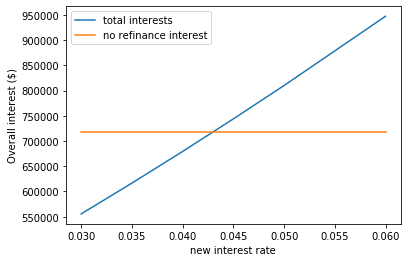

In [21]:
# 30yr fixed
m2 = mortgage.Mortgage(interest=ORIGIN_INTEREST, amount=INITIAL_AMOUNT, months=PERIOD)
res = refinance(m2, 0, remaining=PERIOD)
total_interest = res[0]+res[2]

# for 7/1ARM
m = mortgage.Mortgage(interest=ORIGIN_INTEREST-0.005, amount=INITIAL_AMOUNT, months=PERIOD)

interest_rates = [0.06, 0.05, 0.045, 0.04, 0.035,0.03]

res = [refinance(m, 84, new_interest=r, remaining=PERIOD-84) for r in interest_rates]
interests = [r[0]+r[2] for r in res]

plt.plot(interest_rates, interests, label='total interests')
plt.plot(interest_rates, [total_interest]*len(interest_rates), label='no refinance interest')
plt.xlabel('new interest rate')
plt.ylabel('Overall interest ($)')
plt.legend()


Let's change the strategy and pay as low as the original payment for the 30yr fixed rate.
Here shows what will happen  - we are better if the rate raises less than 0.5%.

In [23]:
def overpay2(interest, amount, months, new_interest, month_to_change=84, payment=None):
  import decimal
  m = mortgage.Mortgage(interest=interest, amount=amount, months=months) # 30yr fixed
  payment = payment if payment is not None else m.monthly_payment()
  amount = mortgage.dollar(m.amount())
  
  m = mortgage.Mortgage(interest=interest-0.005, amount=amount, months=months) # 7/1ARM
  month = 0
  rate = decimal.Decimal(str(m.rate())).quantize(decimal.Decimal('.000001'))
  total_interest = decimal.Decimal(0)
  balance = mortgage.dollar(m.amount())
  while month < month_to_change and balance > 0:
    interest_unrounded = balance * rate * decimal.Decimal(1)/mortgage.MONTHS_IN_YEAR
    interest = mortgage.dollar(interest_unrounded, round=decimal.ROUND_HALF_UP)
    total_interest += interest
    principle = payment - interest
    balance -= principle
    month += 1
  if balance <= 0:
    return month, total_interest
  m2 = mortgage.Mortgage(interest=new_interest, amount=balance, months=months-month_to_change)
  payment = payment if payment > m2.monthly_payment() else m2.monthly_payment()
  res = m2.month_to_mature(payment=payment)
  return month+res[0], total_interest+res[1]

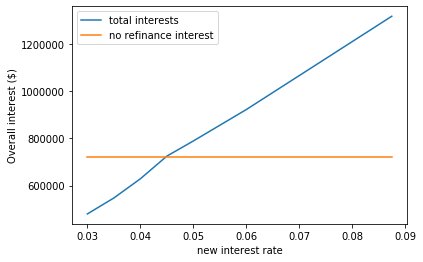

In [24]:
# 30yr fixed
m2 = mortgage.Mortgage(interest=ORIGIN_INTEREST, amount=INITIAL_AMOUNT, months=PERIOD)
res = refinance(m2, 0, remaining=PERIOD)
total_interest = res[0]+res[2]

# for 7/1ARM
m = mortgage.Mortgage(interest=ORIGIN_INTEREST-0.005, amount=INITIAL_AMOUNT, months=PERIOD)

interest_rates = [0.0875,0.06, 0.05, 0.045, 0.04, 0.035, 0.03]

res = [overpay2(ORIGIN_INTEREST, INITIAL_AMOUNT, PERIOD, r) for r in interest_rates]
interests = [r[1] for r in res]

plt.plot(interest_rates, interests, label='total interests')
plt.plot(interest_rates, [total_interest]*len(interest_rates), label='no refinance interest')
plt.xlabel('new interest rate')
plt.ylabel('Overall interest ($)')
plt.legend()

## Acknowledgement

The work is done on [colab](https://colab.research.google.com).